In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-07-13 10:43:00.108715: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import os

num_corrupted = 0
base_dir = '/Users/suprita/supriML/image_classification/bts_dataset'

for folder_name in ('RM', 'Jin', 'Suga', 'J-Hope', 'Jimin', 'Jungkook', 'V'):
    folder_path = os.path.join(base_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            with open(fpath, 'rb') as fobj:
                is_jfif = b'JFIF' in fobj.peek(10)
        except FileNotFoundError:
            print(f'File {fpath} not found.')
            continue
        except Exception as e:
            print(f'Error reading {fpath}: {e}')
            continue
            
        # image is corrupted
        if not is_jfif:
            num_corrupted += 1
            os.remove(fpath)

print(f'Total corrupted images deleted: {num_corrupted}')


Total corrupted images deleted: 75


In [2]:
# data augmentation and creating datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

image_size = (150, 150)
batch_size = 32 # efficient

# image cleaning and normalization
train_gen = ImageDataGenerator(
    rescale = 1./255, # normalize pixels
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2, # 80-20 split
    preprocessing_function=lambda img: cv2.resize(img, (150, 150)) # resize
)

test_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# generate datasets
train_ds = train_gen.flow_from_directory(
    'bts_dataset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # set as training data
)

test_ds = test_gen.flow_from_directory(
    'bts_dataset',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # set as validation data
)

Found 223 images belonging to 7 classes.
Found 52 images belonging to 7 classes.


(32, 150, 150, 3)


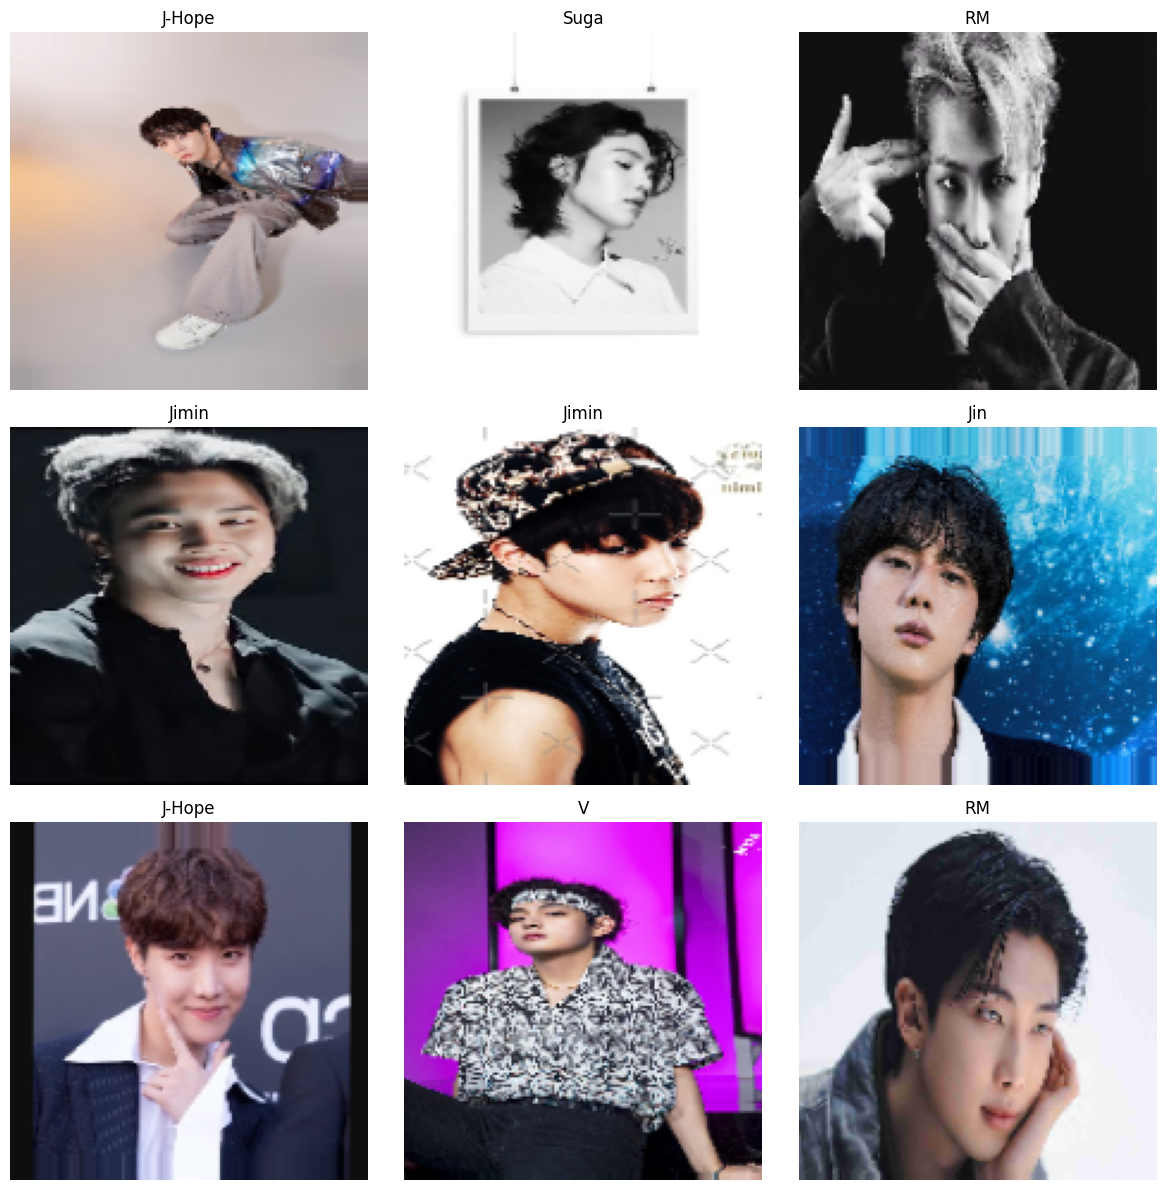

In [3]:
# visualize data

class_names = list(train_ds.class_indices.keys())

plt.figure(figsize=(12, 12))
for images, labels in train_ds:
    for i in range(min(len(images), 9)): 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        class_idx = labels[i].argmax()
        plt.title(class_names[class_idx])  
        plt.axis("off")
        if i == 0: print(images.shape)
    break  # break after first batch
plt.tight_layout()
plt.show()




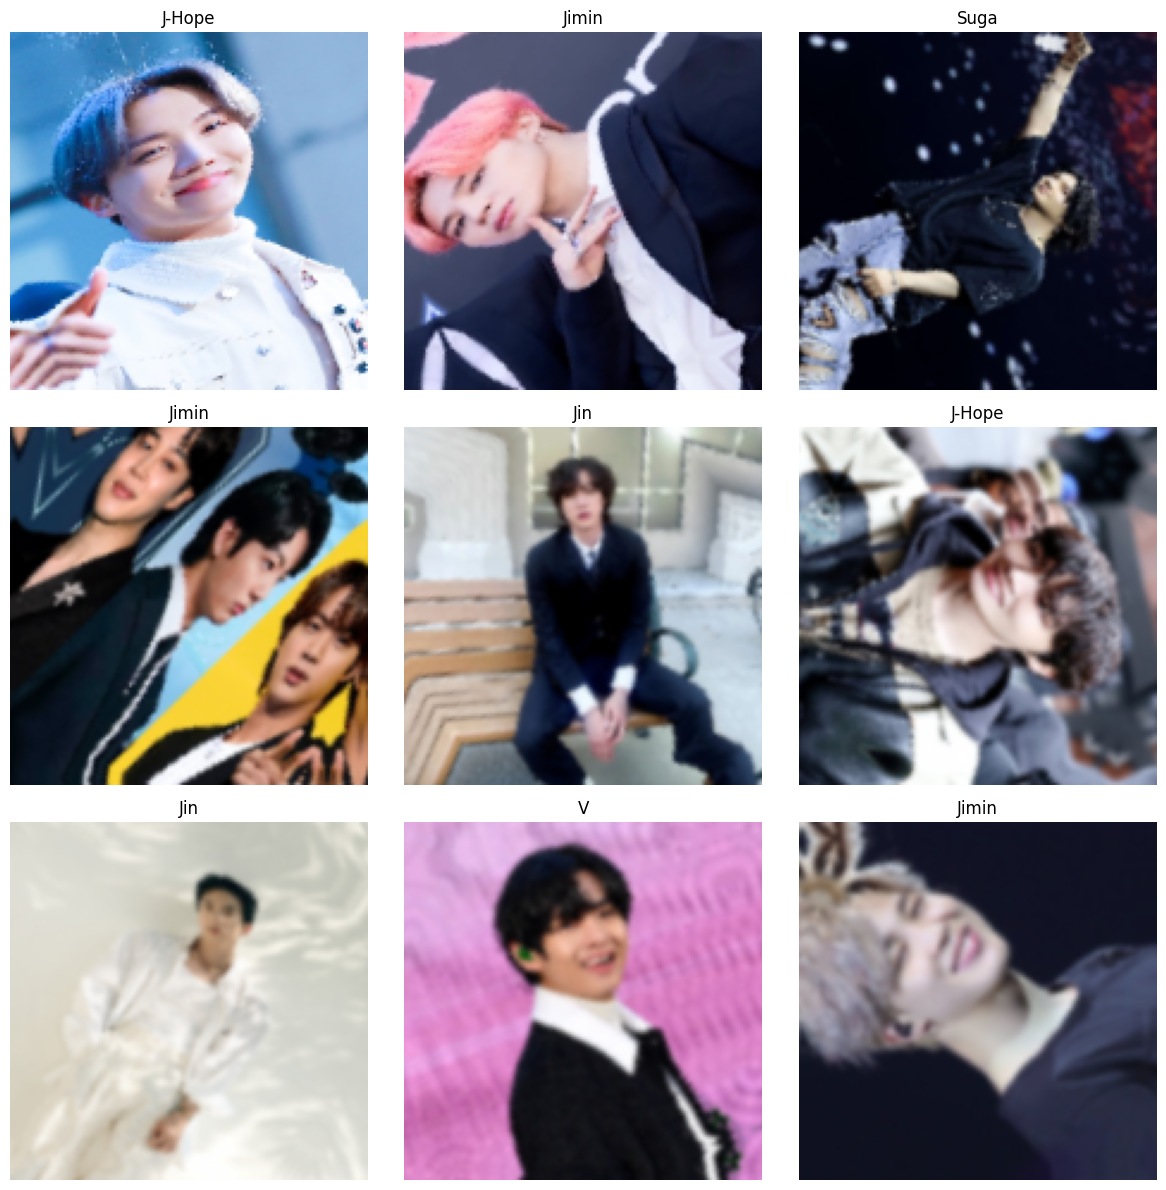

In [34]:
# data augmentation for better fitting
augment_layers = [
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1)
]

def augment(imgs):
    for layer in augment_layers:
        imgs = layer(imgs)
    return imgs

# visualize augmented data
plt.figure(figsize=(12, 12))
for images, labels in train_ds:
    for i in range(min(len(images), 9)): 
        images = augment(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        class_idx = labels[i].argmax()
        plt.title(class_names[class_idx])  
        plt.axis("off")
    break  
plt.tight_layout()
plt.show()



In [3]:
import tensorflow as tf

# convert to tensorflow datasets
train_ds = tf.data.Dataset.from_generator(
    lambda: train_ds,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 150, 150, 3], [None, 7])  # Adjust shapes as per your data
)

test_ds = tf.data.Dataset.from_generator(
    lambda: test_ds,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 150, 150, 3], [None, 7])  # Adjust shapes as per your data
)


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [5]:
# building cnn
def neuralnet(input_shape, num_classes):
    # input layer
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0/255)(inputs) # preprocessing

    # entry block
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x) # 2Dconvolutional layer
    x = layers.BatchNormalization()(x) # normalize activations
    x = layers.Activation('relu')(x) # apply relu

    prev_activations = x  # save activations for residual shortcuts

    # feature extraction layers
    for size in [256, 512, 728]:
        x = layers.Activation('relu')(x) # apply relu
        x = layers.SeparableConv2D(size, 3, padding='same')(x) # separable 2Dconv layer
        x = layers.BatchNormalization()(x) # normalize activations

        x = layers.Activation('relu')(x) 
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x) # pooling

        # residual shortcuts to skip layers as needed
        residual = layers.Conv2D(size, 1, strides=2, padding='same')(prev_activations) 
        x = layers.add([x, residual])
        prev_activations = x  # update prev activations

    # final block
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # output dense layer
    outputs = layers.Dense(num_classes, activation=None)(x)
    
    model = keras.Model(inputs, outputs)
    return model

cnn = neuralnet(input_shape=(150, 150, 3), num_classes=7)
cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4), # adam learning optimization function
    loss=keras.losses.BinaryCrossentropy(from_logits=True), # binary crossentropy loss function
    metrics=[keras.metrics.BinaryAccuracy(name='acc')] # binary accuracy metric
)

epochs = 25
callbacks = [keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras')]

cnn.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds
)


Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - acc: 0.8571 - loss: 0.6192 - val_acc: 0.8571 - val_loss: 0.6868
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - acc: 0.8571 - loss: 0.4367 - val_acc: 0.8571 - val_loss: 0.6828
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - acc: 0.8571 - loss: 0.4078 - val_acc: 0.8571 - val_loss: 0.6808
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - acc: 0.8571 - loss: 0.4102 - val_acc: 0.8571 - val_loss: 0.6792
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - acc: 0.8563 - loss: 0.4020 - val_acc: 0.8571 - val_loss: 0.6778
Epoch 6/25


2024-07-13 10:53:23.341652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-13 10:53:23.343068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - acc: 0.8571 - loss: 0.3927 - val_acc: 0.8571 - val_loss: 0.6765
Epoch 7/25


2024-07-13 10:54:34.523727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-13 10:54:34.525310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - acc: 0.8568 - loss: 0.3823 - val_acc: 0.8571 - val_loss: 0.6750
Epoch 8/25


2024-07-13 10:55:44.541851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-07-13 10:55:45.627744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - acc: 0.8566 - loss: 0.3849 - val_acc: 0.8571 - val_loss: 0.6735
Epoch 9/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - acc: 0.8575 - loss: 0.3761 - val_acc: 0.8571 - val_loss: 0.6722
Epoch 10/25


2024-07-13 10:58:05.551771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-13 10:58:05.553301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 8s/step - acc: 0.8623 - loss: 0.3637 - val_acc: 0.8571 - val_loss: 0.6707
Epoch 11/25


2024-07-13 10:59:08.988522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-13 10:59:08.989775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 8s/step - acc: 0.8581 - loss: 0.3690 - val_acc: 0.8571 - val_loss: 0.6687
Epoch 12/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - acc: 0.8591 - loss: 0.3654 - val_acc: 0.8571 - val_loss: 0.6665
Epoch 13/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 9s/step - acc: 0.8615 - loss: 0.3502 - val_acc: 0.8571 - val_loss: 0.6642
Epoch 14/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 9s/step - acc: 0.8633 - loss: 0.3568 - val_acc: 0.8571 - val_loss: 0.6619
Epoch 15/25


2024-07-13 11:03:20.088990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-13 11:03:20.101673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step - acc: 0.8652 - loss: 0.3426 - val_acc: 0.8571 - val_loss: 0.6594
Epoch 16/25


2024-07-13 11:04:31.943448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-13 11:04:31.944768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - acc: 0.8693 - loss: 0.3240 - val_acc: 0.8571 - val_loss: 0.6567
Epoch 17/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 8s/step - acc: 0.8661 - loss: 0.3077 - val_acc: 0.8571 - val_loss: 0.6537
Epoch 18/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - acc: 0.8744 - loss: 0.2964 - val_acc: 0.8571 - val_loss: 0.6504
Epoch 19/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 9s/step - acc: 0.8728 - loss: 0.2943 - val_acc: 0.8571 - val_loss: 0.6468
Epoch 20/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 8s/step - acc: 0.8803 - loss: 0.2867 - val_acc: 0.8571 - val_loss: 0.6427
Epoch 21/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - acc: 0.8775 - loss: 0.2742 - val_acc: 0.8571 - val_loss: 0.6383
Epoch 22/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - acc: 0.8777 - loss: 0.2794 - val_acc: 0.8571 - val_loss: 0.6339
Epoch 23/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - acc: 0.8892 - loss: 0.2647 - val_acc: 0.8571 - val_loss: 0.6296
Epoch 24/25


2024-07-13 11:12:25.175768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-13 11:12:25.176925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 8s/step - acc: 0.8873 - loss: 0.2516 - val_acc: 0.8571 - val_loss: 0.6248
Epoch 25/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - acc: 0.8864 - loss: 0.2466 - val_acc: 0.8571 - val_loss: 0.6197


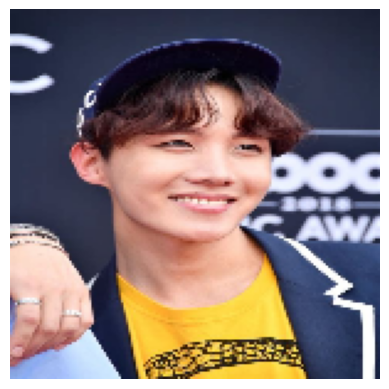

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
I think this is a picture of J-Hope.


In [27]:
# test cnn
labels = ('RM', 'Jin', 'Suga', 'J-Hope', 'Jimin', 'Jungkook', 'V')
img_path = '/Users/suprita/supriML/image_classification/unknown.jpeg'
img = cv2.imread(img_path)
img = cv2.resize(img, (150, 150))  # resize
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to rgb
plt.imshow(img)
plt.axis('off')
plt.show()

# convert img to array for prediction
img_array = keras.utils.img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)  #reshape to (1, 150, 150, 3)

# predict
prediction = cnn.predict(img_array)
idx = np.argmax(prediction)
labels = ('RM', 'Jin', 'Suga', 'J-Hope', 'Jimin', 'Jungkook', 'V')

member = labels[idx]
print(f'I think this is a picture of {member}.')
